In [1]:
import pathlib

import hubbardml
from hubbardml import keys, plots, similarities
import numpy as np
import torch

hubbardml.utils.random_seed()

dtype = torch.float32
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device, torch.get_default_dtype()

('cuda', torch.float32)

In [2]:
VALIDATE_PERCENTAGE = 0.2
DATASET = "../data/data_uv_unique_inout_2023_2_8.json"

SAVEFIGS = False
TARGET_PARAM = 'U'


def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

In [3]:
df = hubbardml.datasets.load(DATASET)

## Input creation

Filter the DF to keep things we want

In [4]:
species = list(df[keys.ATOM_1_ELEMENT].unique())
species = ("Mn", "Fe", "Ni")
graph = hubbardml.graphs.UGraph(species)

df = graph.prepare_dataset(df)
print(len(df))

df = graph.identify_duplicates(
    df,
    tolerances=dict(occs_tol=1e-4, param_tol=5e-4)
)
print(len(df[df[keys.TRAINING_LABEL] == keys.DUPLICATE]))
print(len(df[similarities.CLUSTER_ID].unique()))

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


414


/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


185
229


In [5]:
print(f"Data splits set:\n{df[keys.TRAINING_LABEL].value_counts()}")

Data splits set:
duplicate    185
Name: training_label, dtype: int64


## Model creation

In [6]:
model = hubbardml.models.UModel(
    graph,
    feature_irreps="4x0e + 4x1e + 4x2e",
    hidden_layers=2,
    rescaler=hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean"),
    irrep_normalization="component",
)
model.to(dtype=dtype, device=device)

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


UModel(
  (layers): ModuleList(
    (0): TensorSquare(4x0e+1x2e+1x4e+2x0e+1x2e+1x4e+1x0e+1x2e+1x4e+1x6e+1x8e+1x0e -> 12x0e+4x1e+4x2e | 828 paths | 828 weights)
    (1): Gate (12x0e+4x1e+4x2e -> 4x0e+4x1e+4x2e)
    (2): TensorSquare(4x0e+4x1e+4x2e -> 12x0e+4x1e+4x2e | 744 paths | 744 weights)
    (3): Gate (12x0e+4x1e+4x2e -> 4x0e+4x1e+4x2e)
    (4): TensorSquare(4x0e+4x1e+4x2e -> 1x0e | 30 paths | 30 weights)
    (5): Rescaler(shift=7.4100007246376824,scale=1.873380875120764)
  )
)

## Split test/train

In [7]:
# hubbardml.datasets.split(df, method='category', frac=0.2, category=["species"])
df = hubbardml.datasets.split_by_cluster(df, frac=0.2, category=["species"], ignore_already_labelled=True)

In [8]:
# Get the indices of the training and validation data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

# print(df.loc[train_idx][keys.ATOM_1_ELEMENT].value_counts())
# print(df.loc[validate_idx][keys.ATOM_1_ELEMENT].value_counts())
print(df.groupby([keys.TRAINING_LABEL, keys.ATOM_1_ELEMENT]).size())

training_label  atom_1_element
duplicate       Fe                  2
                Mn                 16
                Ni                 23
train           Fe                 63
                Mn                119
                Ni                146
validate        Fe                 13
                Mn                 20
                Ni                 12
dtype: int64


In [78]:
trainer = hubbardml.Trainer.from_frame(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=0.005),
    loss_fn=torch.nn.MSELoss(),
    frame=df,
    target_column=keys.PARAM_OUT,
    batch_size=16,
)

In [ ]:
trainer.overfitting_window = 400

trainer.train(
    callback=lambda trainer: print(trainer.status()),
    callback_period=50,
    max_epochs=2_000,
)

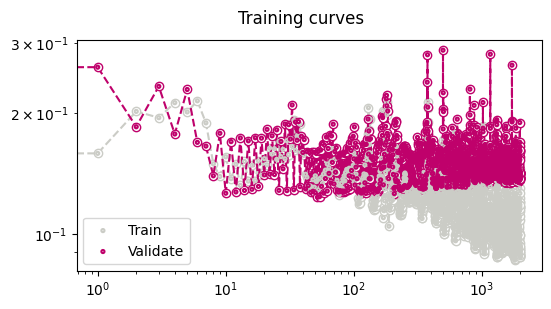

In [80]:
fig = trainer.plot_training_curves();
if SAVEFIGS:
    fig.savefig(plotfile('+U_training'), bbox_inches='tight')
fig.gca().set_xscale("log")

In [81]:
with torch.no_grad():
    train_predicted = hubbardml.engines.evaluate(model, trainer.train_loader).detach().cpu().numpy().reshape(-1)
    val_predicted = hubbardml.engines.evaluate(model, trainer.validate_loader).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = val_predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = train_predicted

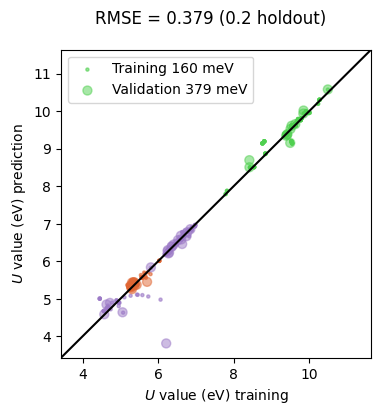

In [82]:
def rmse(y1, y2):
    return np.sqrt(((y1 - y2) ** 2).mean())


df_validate = df.loc[validate_idx]
validate_rmse = hubbardml.datasets.rmse(df_validate)
plots.create_parity_plot(df, title=f'RMSE = {validate_rmse:.3f} ({VALIDATE_PERCENTAGE} holdout)',
                         axis_label=f'${TARGET_PARAM}$ value (eV)');

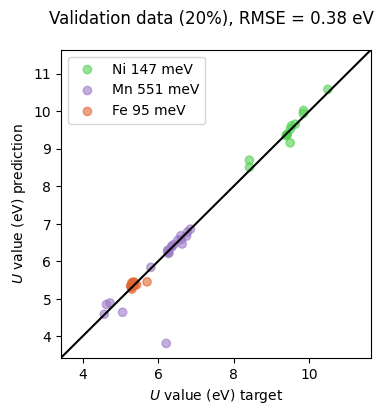

In [83]:
fig = plots.split_plot(df_validate, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

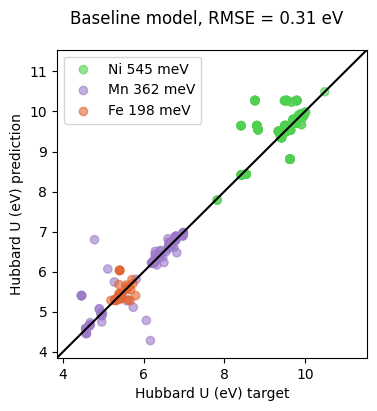

In [84]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(df_ref, keys.ATOM_1_ELEMENT, axis_label=f'Hubbard {TARGET_PARAM} (eV)',
                       title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref):.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

In [85]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(
    df_ref,
    keys.ATOM_1_ELEMENT,
    axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref, label="both"):.2f} eV',
);

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

TypeError: rmse() got an unexpected keyword argument 'label'

In [ ]:
{str(pathlib.Path(directory).parent) for directory in df[keys.DIR].unique()}

In [ ]:
max_range = df[keys.PARAM_OUT].max() - df[keys.PARAM_OUT].min()
max_range = max(max_range, (df[keys.PARAM_OUT_PREDICTED].max() - df[keys.PARAM_OUT_PREDICTED].min()))
print(max_range)

plots.create_progression_plots(
    df,
    '/home/azadoks/Projects/uv_ml/data/iurii/Olivines/LiMnPO4/B2_Li0.25MnPO4/DFT_plus_UV',
    yrange=1.2
);

In [ ]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_u/steps_{idx}_+U.pdf', bbox_inches='tight')
            idx += 1

In [ ]:
import copy

fig, ax = copy.deepcopy(model.tp1).cpu().visualize()
# ax.get_lines()[0].set_color('black')
for patch in ax.patches:
    patch.set_color(plots.plot_colours[2])

if SAVEFIGS:
    fig.savefig('plots/hubbard_u_tp.pdf', bbox_inches='tight')

In [ ]:
df[df[keys.PARAM_IN] == 0.][keys.TRAINING_LABEL]
